<a href="https://colab.research.google.com/github/cu7th0n/ssq/blob/master/Copy_of_ssq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import requests
from bs4 import BeautifulSoup
import xlwt
import time

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

#将数据写入Excel表格中
def write_to_excel():
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    for k in range(1,120):
        url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_%s.html' %(str(k))
        html = get_one_page(url)
        
        #写入每一期的信息
        for item in parse_one_page(html):
            sheet1.write(i+1,0,item['time'])
            sheet1.write(i+1,1,item['digit_1'])
            sheet1.write(i+1,2,item['digit_2'])
            sheet1.write(i+1,3,item['digit_3'])
            sheet1.write(i+1,4,item['digit_4'])
            sheet1.write(i+1,5,item['digit_5'])
            sheet1.write(i+1,6,item['digit_6'])
            sheet1.write(i+1,7,item['digit_7'])
            i+=1
    
    f.save('ssq.xls')
    print('%d页已保存。'%k)
    
def main():
    write_to_excel()

if __name__ == '__main__':
    main()

119页已保存。


In [0]:
import pandas as pd
data = pd.read_excel('ssq.xls')

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data.reset_index(inplace=True)
del data['index']
del data['date']

In [97]:
data.columns[0]

'digit_1'

In [0]:
D_1 = data['digit_1']
D_2 = data['digit_2']
D_3 = data['digit_3']
D_4 = data['digit_4']
D_5 = data['digit_5']
D_6 = data['digit_6']
D_7 = data['digit_7']

In [0]:
tdatas = [D_1, D_2, D_3, D_4, D_5, D_6, D_7]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


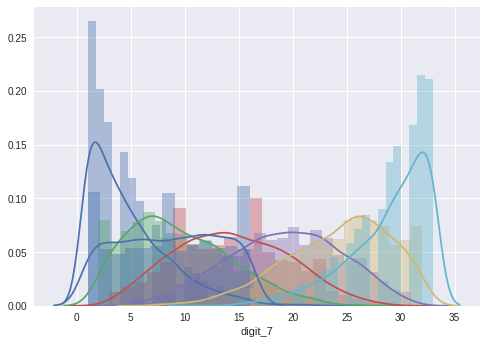

In [94]:
import seaborn as sns

sns.set_style('darkgrid')
for (d,l) in zip(tdatas,data.columns):
  sns.distplot(d,label=l)


In [0]:
import numpy as np

def create_interval_dataset(dataset, look_back):
    """
    :param dataset: input array of time intervals
    :param look_back: each training set feature length
    :return: convert an array of values into a dataset matrix.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:i+look_back])
        dataY.append(dataset[i+look_back])
    return np.asarray(dataX), np.asarray(dataY)


In [0]:
def train_model(train_set,mname,look_back = 200,data_dim = 34,batch_size = 1):
  from keras.utils import to_categorical
  from keras.models import Sequential
  from keras.layers import LSTM, Dense, Dropout
  import numpy as np

  timesteps = look_back
 
  # Expected input batch shape: (batch_size, timesteps, data_dim)
  # Note that we have to provide the full batch_input_shape since the network is stateful.
  # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
  model = Sequential()
  model.add(LSTM(data_dim, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(LSTM(data_dim*2, return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  model.add(LSTM(data_dim*4, return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  model.add(LSTM(data_dim*8, stateful=True))
  model.add(Dense(data_dim, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

  df = to_categorical(train_set,data_dim)
  
  dataX, dataY = create_interval_dataset(df, look_back) 
  
  total = len(train_set)
  split = total*8//10

  X_train = dataX[:split]
  y_train = dataY[:split]

  X_val = dataX[split+1:total-1]
  y_val = dataY[split+1:total-1]
  
  model.fit(X_train, y_train,batch_size=batch_size, epochs=1,
            shuffle=False,validation_data=(X_val, y_val))
  model.save(mname)


In [0]:
models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5',
          'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1, D_2, D_3, D_4, D_5, D_6, D_7]

for (model,tdata) in zip(models,tdatas):
  train_model(tdata,model)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1902 samples, validate on 275 samples
Epoch 1/1
1902/1902 [==============================] - 730s 384ms/step - loss: 2.5848 - acc: 0.1656 - val_loss: 2.5521 - val_acc: 0.2218
Train on 1902 samples, validate on 275 samples
Epoch 1/1
1902/1902 [==============================] - 762s 401ms/step - loss: 3.0576 - acc: 0.0810 - val_loss: 2.9530 - val_acc: 0.0582
Train on 1902 samples, validate on 275 samples
Epoch 1/1
1902/1902 [==============================] - 748s 393ms/step - loss: 3.2078 - acc: 0.0526 - val_loss: 3.2329 - val_acc: 0.0473
Train on 1902 samples, validate on 275 samples
Epoch 1/1
1902/1902 [==============================] - 793s 417ms/step - loss: 3.1869 - acc: 0.0631 - val_loss: 3.0982 - val_acc: 0.0400
Train on 1902 samples, valida

In [42]:
from keras.models import load_model
from keras.utils import to_categorical
models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5', 'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1,D_2,D_3,D_4,D_5,D_6,D_7]

for (model,tdata) in zip(models,tdatas):
    
    print(model)
    M_ssq = load_model(model)

    test_X = to_categorical(np.asarray([tdata[-200:]]),num_classes=34)

    pred = M_ssq.predict(test_X)
    ranks = np.argsort(pred[0])
    
    for i in [1,2,3,4]:
        print(str(ranks[-i]) + ' : %.2f%%' %(pred[0][ranks[-i]]*100))
    print('\n')

M1_model.h5
1 : 20.71%
2 : 18.68%
5 : 12.66%
4 : 12.61%


M2_model.h5
8 : 11.41%
7 : 8.85%
6 : 8.62%
10 : 7.62%


M3_model.h5
8 : 12.28%
12 : 9.52%
16 : 9.52%
14 : 7.64%


M4_model.h5
24 : 8.13%
20 : 7.34%
23 : 7.26%
22 : 7.08%


M5_model.h5
27 : 12.36%
25 : 8.95%
28 : 7.13%
23 : 6.73%


M6_model.h5
33 : 17.45%
32 : 15.62%
30 : 13.48%
29 : 12.15%


M7_model.h5
7 : 11.47%
15 : 10.04%
5 : 9.32%
10 : 9.23%




In [33]:
dataX[-1:].shape

(1, 200, 34)

In [0]:
test_X = to_categorical(np.asarray([D_1[-200:]]),num_classes=34)